# Agar pad simulations 

## This notebook is currently being updated, and is unfinished! 

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import numpy as np
import os
import pickle
from skimage.transform import rescale, rotate
import noise
import matplotlib.pyplot as plt

In [4]:
import sys
sys.path.insert(1, '/home/georgeos/Documents/GitHub/SyMBac/') # Not needed if you installed SyMBac using pip
from SyMBac.drawing import raster_cell
from SyMBac.colony_simulation import ColonySimulation

/home/georgeos/Documents/GitHub/SyMBac/SyMBac/colony_simulation.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [163]:
colonysim = ColonySimulation(
    cellmodeller_model= 'cellmodeller_ex1_simpleGrowth_modified.py',
    max_cells = 100,
    pix_mic_conv = 0.065,
    resize_amount = 3,
    save_dir = "test/"
)

In [6]:
colonysim.run_cellmodeller_sim(num_sim=1)

Set up OpenCL context:
  Platform: NVIDIA CUDA
  Device: Quadro RTX 3000
Importing model cellmodeller_ex1_simpleGrowth_modified
      10           2 cells           0 contacts    0.000046 hour(s) or 0.002738 minute(s) or 0.164258 second(s)
      20           2 cells           0 contacts    0.000056 hour(s) or 0.003390 minute(s) or 0.203377 second(s)
      30           2 cells           1 contacts    0.000072 hour(s) or 0.004332 minute(s) or 0.259929 second(s)
   30     2 cells       1 cts       2 iterations  residual = 0.000027
      40           2 cells           1 contacts    0.000093 hour(s) or 0.005584 minute(s) or 0.335052 second(s)
   40     2 cells       1 cts       2 iterations  residual = 0.000070
      50           2 cells           1 contacts    0.000109 hour(s) or 0.006548 minute(s) or 0.392868 second(s)
   50     2 cells       1 cts       1 iterations  residual = 0.002033
      60           4 cells           4 contacts    0.000126 hour(s) or 0.007563 minute(s) or 0.453777 

In [164]:
colonysim.get_simulation_dirs()

['data/test/1']

In [165]:
pickles = colonysim.get_simulation_pickles()

In [166]:
colonysim.get_max_scene_size()

(2101, 1787)

In [167]:
colonysim.draw_simulation_OPL(n_jobs = -1, FL=False, density = 0.1, random_distribution = np.random.uniform)

Scene Draw:: 0it [00:00, ?it/s]

In [13]:
shape = colonysim.get_max_scene_size()
scale = 5
octaves = 10
persistence = 1.9
lacunarity = 1.8
def perlin_generator(scale, octaves, persistence, lacunarity, resize_amount):
    
    y, x = np.round(shape[0]/resize_amount).astype(int), np.round(shape[1]/resize_amount).astype(int)
    
    world = np.zeros((x,y))

    # make coordinate grid on [0,1]^2
    x_idx = np.linspace(0, 1, y)
    y_idx = np.linspace(0, 1, x)
    world_x, world_y = np.meshgrid(x_idx, y_idx)

    # apply perlin noise, instead of np.vectorize, consider using itertools.starmap()
    world = np.vectorize(noise.pnoise2)(world_x/scale,
                            world_y/scale,
                            octaves=octaves,
                            persistence=persistence,
                            lacunarity=lacunarity)

    # here was the error: one needs to normalize the image first. Could be done without copying the array, though
    img = np.floor((world + .5) * 255).astype(np.uint8) # <- Normalize world first
    return img

In [14]:
def random_perlin_generator():
    return perlin_generator(np.random.uniform(1,7), np.random.choice([10,11,12,13]), np.random.uniform(1,1.9), np.random.uniform(1.55,1.9), resize_amount=3)

In [37]:
from SyMBac.colony_renderer import ColonyRenderer

In [39]:
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import convolve_rescale
from skimage.util import random_noise
from scipy.ndimage import gaussian_filter

from skimage.exposure import rescale_intensity


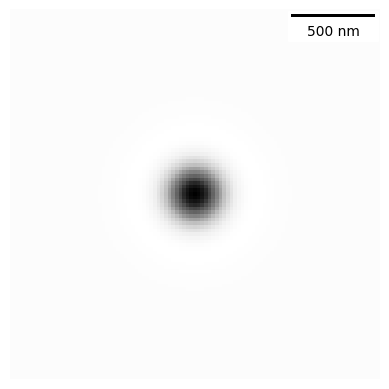

In [180]:
my_kernel = PSF_generator(
    radius = 50, 
    wavelength = 0.75, 
    NA = 1.45, 
    n = 1.4, 
    resize_amount = 3, 
    pix_mic_conv = 0.065, 
    apo_sigma = 8, 
    mode="phase contrast", 
    condenser = "Ph3",
    offset = 0.00000019
)
my_kernel.calculate_PSF()
my_kernel.plot_PSF()


In [181]:
my_renderer = ColonyRenderer(colonysim, my_kernel)

In [186]:
test_img = my_renderer.render_scene(100)

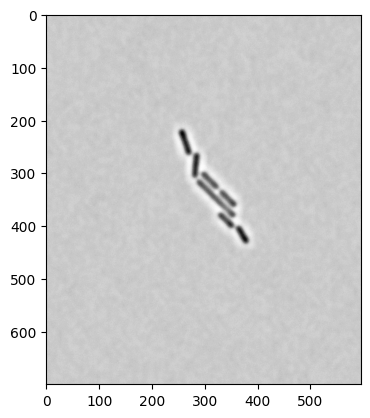

In [187]:
plt.imshow(test_img, cmap="Greys_r")